### Imports

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from IPython import display

tf.config.run_functions_eagerly(True)

### Utilities

In [2]:
def plot_multiple_images(images, n_cols=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
        
    plt.figure(figsize=(n_cols, n_rows))
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index+1)
        plt.imshow(image, cmap='binary')
        plt.axis('off')

### Download and Prepare the Dataset

We will first load the MNIST dataset. For this project, we will just be using the training images so you might notice that we are not getting the test split nor the training labels below. You will also preprocess these by normalizing the pixel values.

In [3]:
(x_train, _), _ = tf.keras.datasets.fashion_mnist.load_data()

x_train = x_train.astype(np.float32) / 255

# reshape and rescale
x_train = x_train.reshape(-1, 28, 28, 1) * 2. - 1.

In [4]:
BATCH_SIZE = 128
dataset = tf.data.Dataset.from_tensor_slices(x_train).shuffle(1000)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True).prefetch(1)

## Build the Model

We will now create the two main parts of the GAN: 
* generator - creates the fake data
* discriminator - determines if an image is fake or real

We will stack Dense layers using the Sequential API to build these sub networks.

### Generator

For the generator, we take in random noise and eventually transform it to the shape of the Fashion MNIST images. The general steps are:

* Feed the input noise to a dense layer.
* Reshape the output to have three dimensions. This stands for the (length, width, number of filters).
* Perform a deconvolution (with [Conv2DTranspose](https://www.tensorflow.org/api_docs/python/tf/keras/layers/Conv2DTranspose)), reducing the number of filters by half and using a stride of `2`.
* The final layer upsamples the features to the size of the training images. In this case 28 x 28 x 1.

Notice that batch normalization is performed except for the final deconvolution layer. As best practice, `selu` is the activation used for the intermediate deconvolution while `tanh` is for the output. We printed the model summary so you can see the shapes at each layer.



In [5]:
random_normal_dimension = 32

generator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[random_normal_dimension]),
    tf.keras.layers.Dense(7 * 7 * 128),
    tf.keras.layers.Reshape([7, 7, 128]),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(filters=64, activation='selu', padding='same', strides=2, kernel_size=5),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv2DTranspose(filters=1, padding='same', activation='tanh', strides=2, kernel_size=5),
])

generator.summary()### Generator

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 6272)                │         206,976 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 14, 14, 64)          │         204,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,601 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 414,209 (1.58 MB)

 Trainable params: 413,825 (1.58 MB)

 Non-trainable params: 384 (1.50 KB)

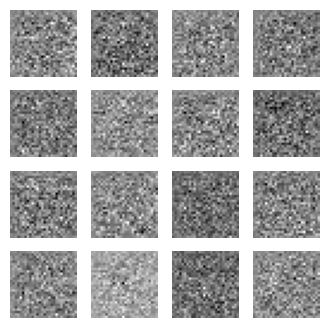

In [6]:
test_noise = tf.random.normal([16, random_normal_dimension])

test_image = generator(test_noise)

plot_multiple_images(test_image, n_cols=4)

### Discriminator

The discriminator will use strided convolutions to reduce the dimensionality of the input images. As best practice, these are activated by [LeakyRELU](https://keras.io/api/layers/activation_layers/leaky_relu/). The output features will be flattened and fed to a 1-unit dense layer activated by `sigmoid`.

In [7]:
discriminator = tf.keras.models.Sequential([
    tf.keras.layers.Input(shape=[28, 28, 1]),
    tf.keras.layers.Conv2D(filters=64, activation=tf.keras.layers.LeakyReLU(0.2), padding='same', kernel_size=5, strides=2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Conv2D(filters=128, activation=tf.keras.layers.LeakyReLU(0.2), padding='same', kernel_size=5, strides=2),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation='sigmoid')
])
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

## Configure Training Parameters

You will now prepare the models for training. We can measure the loss with `binary_crossentropy` because you're expecting labels to be either 0 (fake) or 1 (real).

In [8]:
gan = tf.keras.models.Sequential([generator, discriminator])

In [9]:
discriminator.compile(loss="binary_crossentropy", optimizer="rmsprop")
discriminator.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

## Train the Model

Next, we will define the training loop. This consists of two phases:

* Phase 1 - trains the discriminator to distinguish between fake or real data
* Phase 2 - trains the generator to generate images that will trick the discriminator

At each epoch, you will display a sample gallery of images to see the fake images being created by the generator.

In [10]:
def train_gan(gan, dataset, random_normal_dimension, n_epochs=50):
    generator, discriminator = gan.layers
    
    for epoch in range(n_epochs):
        print('Epoch {}/{}'.format(epoch + 1, n_epochs))
        
        for real_images in dataset:
            
            batch_size = real_images.shape[0]
            
            # Train the discriminator - PHASE 1
            noise = tf.random.normal(shape=[batch_size, random_normal_dimension])
            
            fake_images = generator(noise)
            
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            
            discriminator.trainable = True
            
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            # Train the generator - PHASE 2
            noise = tf.random.normal(shape=[batch_size, random_normal_dimension])
            
            generator_labels = tf.constant([[1.]] * batch_size)
            
            discriminator.trainable = False
            
            gan.train_on_batch(noise, generator_labels)
            
        plot_multiple_images(fake_images, 8)
        plt.show()

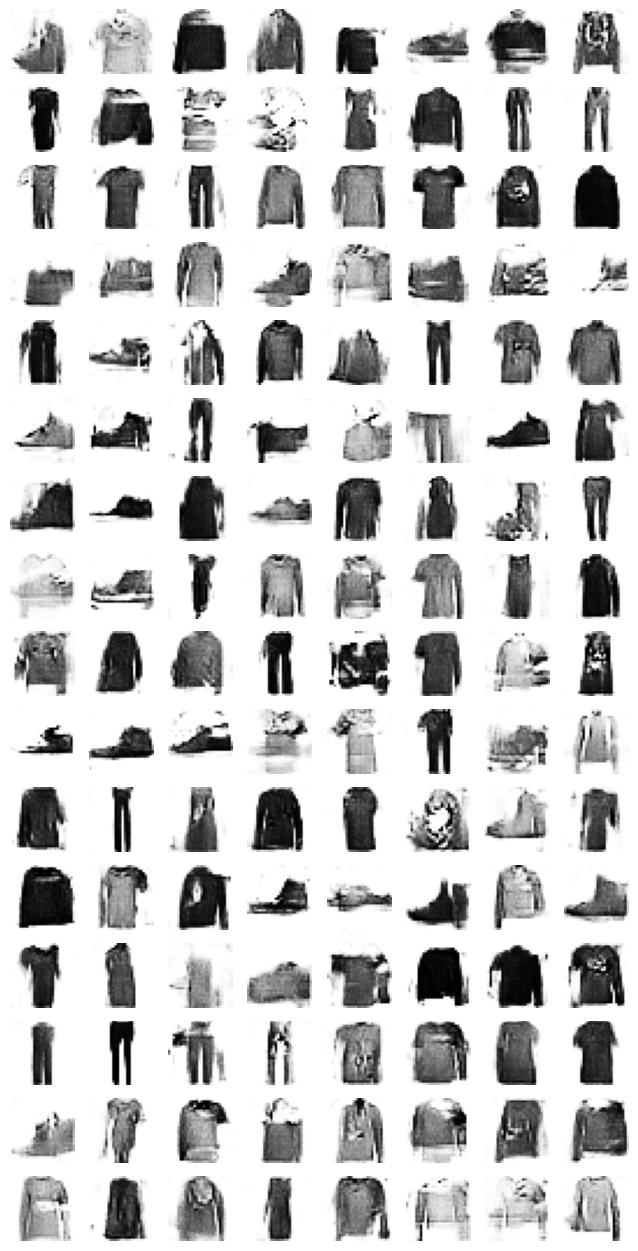

In [12]:
train_gan(gan, dataset, random_normal_dimension, n_epochs=5)